# Support points with Exponential Mechanism

### Procedure:


1. Given data $X = \{x_1, \ldots, x_M\}$ on space $\mathcal{D} \in [0, 1]^d$, find optimal support points $Y = \{y_1, \ldots, y_N\}$.
2. Using energy distance (with Lp norm) as the score function of the exponential mechanism, the sensitivity is $\Delta f = \frac{2 d^{1/p}(2N - 1)}{N^2}$. The exponential mechanism samples a new energy value $\tilde{e} \sim \mbox{Exp}(\frac{2\Delta f}{\alpha})$, where $\alpha$ is the privacy budget.
3. Let $\tilde{Y}$ be a copy of $Y$. While $e(\tilde{Y}, Y) < \tilde{e}$, perturb all points in $\tilde{Y}$ with small step in a random direction.

---

 
Note: Exponential samples (i.e. energy distances) are larger with:
  - small privacy budget, $\alpha$
  - large sensitivity, $\Delta f$
  - large dimensionality, $d$
  - small energy exponent, $p$
  - small support point set, $N$.

___

# 0. Helper Functions

In [1]:
%matplotlib inline

import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pdb
from scipy.spatial.distance import pdist
import sys
import tensorflow as tf
import time

from data import load_balog_data
from sp_utils import (
    get_support_points,
    energy,
    sample_sp_exp_mech,
    sample_sp_mmd_dp_bw,
    mixture_model_likelihood,
    sample_full_set_by_diffusion)

matplotlib.rcParams.update({'font.size': 14})
plt.style.use('ggplot')
print(sys.version)
print(tf.__version__)

3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]
1.13.1


In [2]:
np.random.seed(345)

____

# 1. Global Config

Note: Exponential samples (i.e. energy distances) are smaller with:
  - large privacy budget, $\alpha$
  - small sensitivity, $\Delta f$
  - small dimensionality, $d$
  - large energy exponent, $p$
  - large support point set, $N$

In [3]:
# Set global constants.          # main1()
IS_TF = True                     # Boolean. Use TensorFlow rather than analytical gradients.
Y_INIT_OPTION = 'radial'         # ['grid', 'random', 'radial']
MAX_ITER = 301                   # Num iterations in each support point optimization. [301]
LR = 1e-2                        # Energy optimization learning rate. [1e-2]

C = 10                           # Number of clusters in data.
SIGMA_DATA = 0.03                # Bandwidth of data.
M = 200                          # Number of data points.
DIM = 2                          # Dimension of data.

N = 10                           # Number of support points.
ALPHA = 50                       # Differential privacy level.
ENERGY_POWER = 2.                # Power for energy distance kernel.
STEP_SIZE = 1e-3                 # Diffusion and MH step sizes.

___

# 2. Load and Plot Data

In [4]:
# Load data.
x = load_balog_data(M, DIM, C, SIGMA_DATA, make_new=True, do_weighted=True)

Loaded M=200, DIM=2, SIG=0.03, C=10


___

# 3. Run Support Point Optimization


STARTING RUN. is_tf: True, y_init: radial, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
  [*] Overall it/s: 0.0030


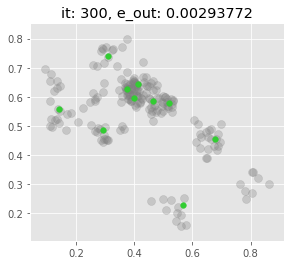

  [*] Time elapsed: 1.0758271217346191


In [5]:
# Compute m support points on full set.
y_opt, e_opt = get_support_points(x, N, MAX_ITER, LR, is_tf=IS_TF)

#### Paper: Figure of support point optimization for variety of cluster sizes and counts.

Loaded M=200, DIM=2, SIG=0.02, C=5

STARTING RUN. is_tf: True, y_init: radial, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 0.8839273452758789
Loaded M=200, DIM=2, SIG=0.02, C=10

STARTING RUN. is_tf: True, y_init: radial, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 0.8843564987182617
Loaded M=200, DIM=2, SIG=0.02, C=30

STARTING RUN. is_tf: True, y_init: radial, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 0.8442513942718506
Loaded M=200, DIM=2, SIG=0.04, C=5

STARTING RUN. is_tf: True, y_init: radial, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 0.8463525772094727
Loaded M=200, DIM=2, SIG=0.04, C=10

STARTING RUN. is_tf: True, y_init: radial, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 0.9145667552947998
Loaded M=200, DIM=2, SIG=0.04, C=30

STARTING RUN. is_tf: True, y_init: radial, clip: bounds, wlb

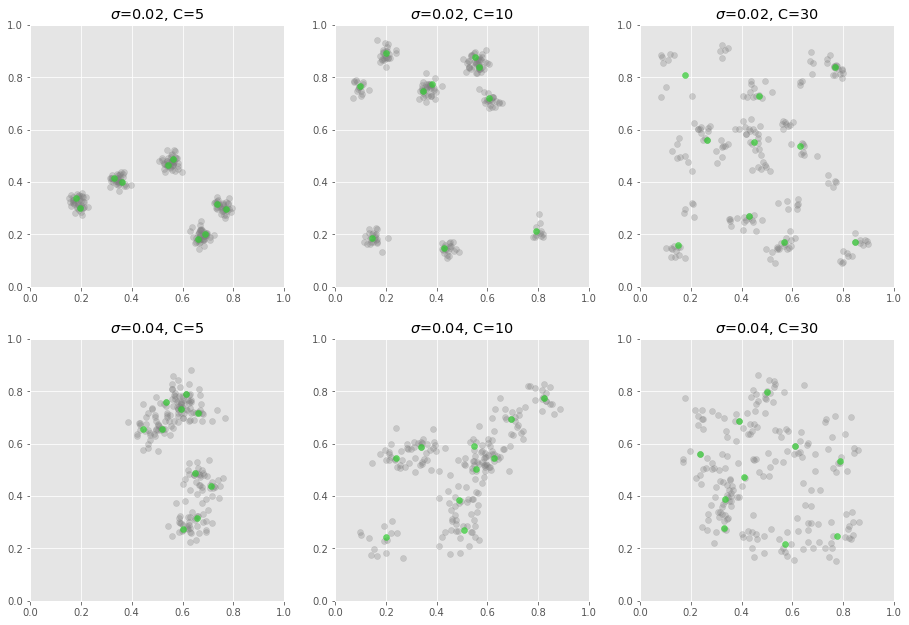

In [6]:
example_sigmas = [0.02, 0.04]
example_clusters = [5, 10, 30]
n_sig = len(example_sigmas)
n_clu = len(example_clusters)

fig, axs = plt.subplots(n_sig, n_clu, figsize=(5 * n_clu, 5 * n_sig))
for i, sigma in enumerate(example_sigmas):
    for j, cluster_count in enumerate(example_clusters):
        temp_data = load_balog_data(M, DIM, cluster_count, sigma, make_new=True,
                                    do_weighted=False)
        temp_y_opt, temp_e_opt = get_support_points(temp_data, N, MAX_ITER,
                                                    LR, is_tf=IS_TF, plot=False)

        axs[i, j].set_title('$\sigma$={}, C={}'.format(sigma, cluster_count))
        axs[i, j].scatter(temp_data[:, 0], temp_data[:, 1], c='gray', alpha=0.3)
        axs[i, j].scatter(temp_y_opt[:, 0], temp_y_opt[:, 1], c='limegreen', alpha=0.7)
        axs[i, j].set_xlim((0, 1))
        axs[i, j].set_ylim((0, 1))


plt.subplots_adjust(wspace=0.2, hspace=0.2,
                    bottom=0.1, top=0.9, left=0.1, right=0.9)
plt.savefig('../output/fig_sp_optimization.png')

___

# 4. Define energy sensitivity.

In [7]:
# Define energy sensitivity for Exponential Mechanism.
# OLD: energy_sensitivity = 2 * DIM ** (1. / ENERGY_POWER) / N ** 2
energy_sensitivity = 2 * DIM ** (1. / ENERGY_POWER) * (2 * N - 1) / N ** 2
print(('Exp(2 * U / alpha) = Exp(2 * {:.4f} / {:.2f}) '
       '= Exp({:.3f})').format(energy_sensitivity, ALPHA, 
                               2. * energy_sensitivity / ALPHA))

Exp(2 * U / alpha) = Exp(2 * 0.5374 / 50.00) = Exp(0.021)


___

## 5. Sample support points.

## 5.0 Sample support points with SP + Exponential Mechanism.

In [8]:
RUN_MH = 1
RUN_DIFFUSION = 1
PLOT = 1



--------- RUNNING MH ----------


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.5374 / 10000.000) = Exp(0.0001)

Running chain. Length=41000, Burn=1000, Thin=200, Step=0.001
Difference factor: 9304.04


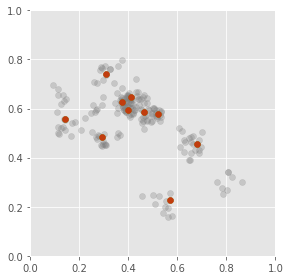

Acceptance rate: 0.0
Energy diff: -0.00027464


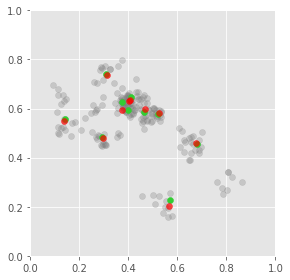

Acceptance rate: 0.6836581709145427
Energy diff: -0.00003545


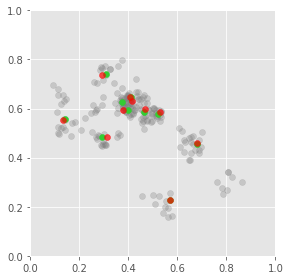

Acceptance rate: 0.6990752311922019
Energy diff: 0.00010437


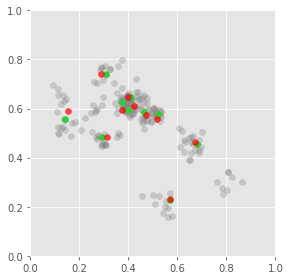

Acceptance rate: 0.6980503249458424
Energy diff: -0.00014445


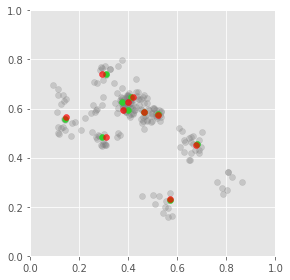

Acceptance rate: 0.6924134483189601
Energy diff: 0.00001121


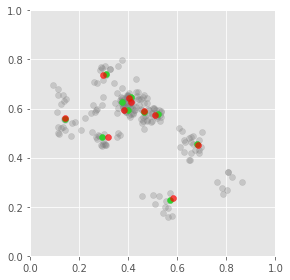

Acceptance rate: 0.6888311168883112
Energy diff: -0.00003438


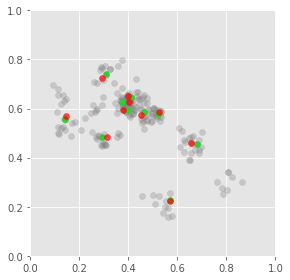

Acceptance rate: 0.6883593033913841
Energy diff: 0.00003713


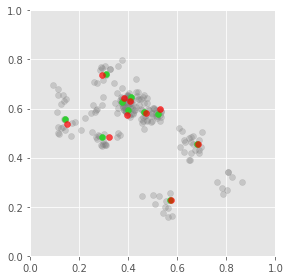

Acceptance rate: 0.6873794728947932
Energy diff: -0.00010164


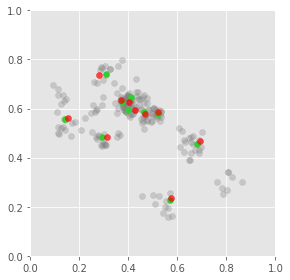

Acceptance rate: 0.6882694831573026
Energy diff: -0.00012689


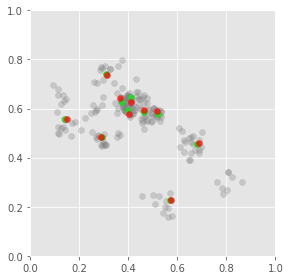

Acceptance rate: 0.6855730237209043
Energy diff: -0.00014116


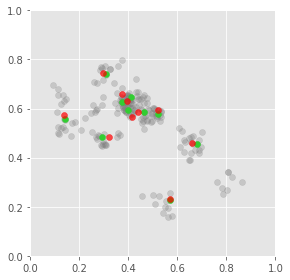

Acceptance rate: 0.6855157242137893
Energy diff: 0.00021767


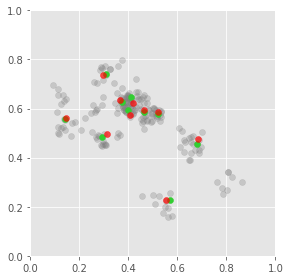

Acceptance rate: 0.6851506749693196
Energy diff: 0.00005170


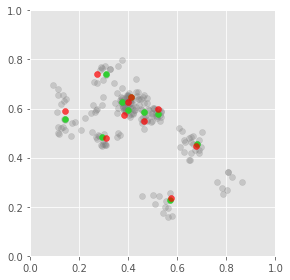

Acceptance rate: 0.6844298154243573
Energy diff: 0.00002035


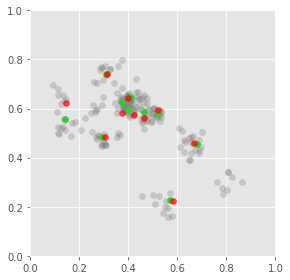

Acceptance rate: 0.6845890542671436
Energy diff: 0.00000344


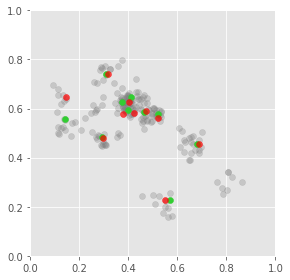

Acceptance rate: 0.6848326845469804
Energy diff: -0.00008968


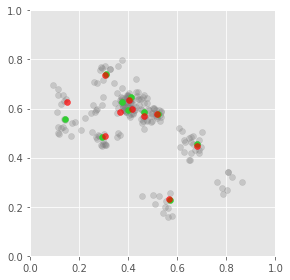

Acceptance rate: 0.6843771874270858
Energy diff: -0.00007469


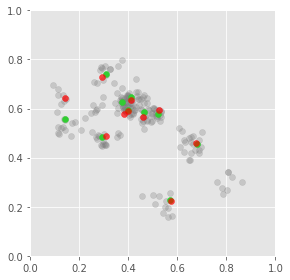

Acceptance rate: 0.6839786256679479
Energy diff: -0.00004589


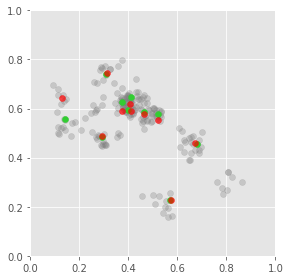

Acceptance rate: 0.6840092938442986
Energy diff: -0.00015361


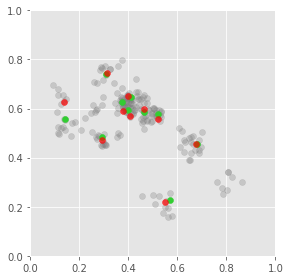

Acceptance rate: 0.6837865614844032
Energy diff: 0.00007792


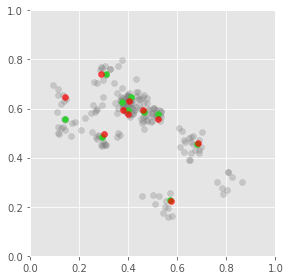

Acceptance rate: 0.6839820004736717
Energy diff: -0.00002011


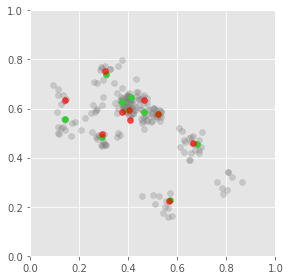

Acceptance rate: 0.68380790480238
Energy diff: -0.00003473


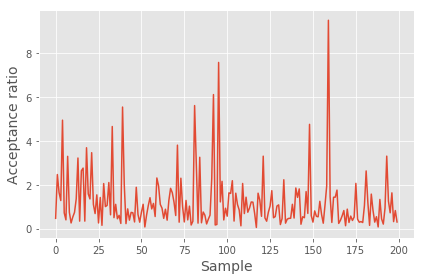

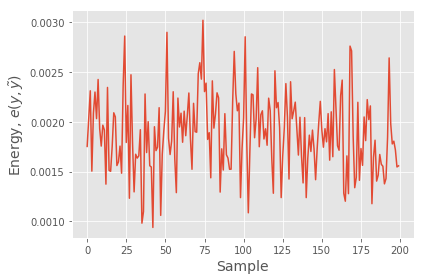

Acceptance ratio: 0.683439024390244
percent steps that improved energy score: 0.34119512195121954


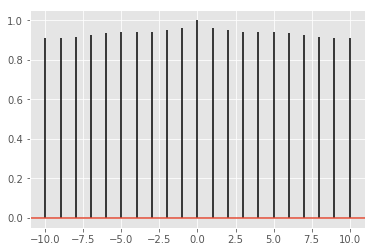

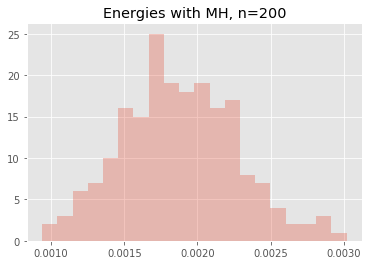

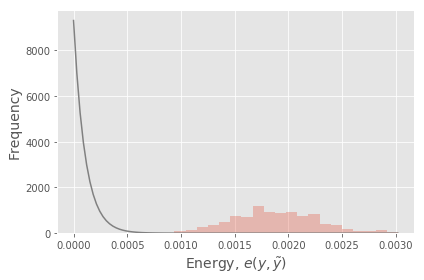

p: 0.00010748023074035522


In [9]:
if RUN_MH:
    # Sampling parameters.
    STEP_SIZE = 1e-3
    NUM_Y_TILDES = 200
    ALPHA_MH = 10000

    METHOD = 'mh'
    print('\n\n--------- RUNNING {} ----------\n'.format(METHOD.upper()))
    (y_tildes_mh,
     energies_mh,
     _) = sample_sp_exp_mech(e_opt, energy_sensitivity, x, y_opt,
                             METHOD, STEP_SIZE, NUM_Y_TILDES, ALPHA_MH,
                             plot=PLOT)
    
    if PLOT:
        #plt.title('Energies with MH, {} samples'.format(len(energies_mh)))
        plt.hist(energies_mh, bins=20, alpha=0.3, density=True, label='Samples')
        
        
        # Compare to Exponential density.
        p = exponential_param = 2. * energy_sensitivity / ALPHA_MH
        xs = np.linspace(0, np.max(energies_mh), 100)
        xs_dens = 1 / p * np.exp(-xs / p)
        plt.plot(xs, xs_dens, c='gray', label='Exponential density')
        plt.xlabel(r'Energy, $e(y, \tilde{y})$', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)

        plt.tight_layout()
        plt.savefig('../output/fig_mh_energies.png')
        plt.show()
        print('p: {}'.format(p))



--------- RUNNING DIFFUSION ----------


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.5374 / 50.000) = Exp(0.0215)


Exp. mean: 0.02150, e_tilde: 0.02560
  step_size_factor: 0.59536, adjusted: 0.01 -> 0.00595
  Diffusion count    79, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.02566 - 0.02560) / 0.02560 = 0.00260

Exp. mean: 0.02150, e_tilde: 0.06406
  step_size_factor: 1.48998, adjusted: 0.01 -> 0.01490
  Diffusion count    91, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.06474 - 0.06406) / 0.06406 = 0.01073

Exp. mean: 0.02150, e_tilde: 0.00052
  step_size_factor: 0.02437, adjusted: 0.01 -> 0.00024
  Diffusion count    76, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.00054 - 0.00052) / 0.00052 = 0.03704

Exp. mean: 0.02150, e_tilde: 0.01737
  step_size_factor: 0.80791, adjusted: 0.01 -> 0.00808
  Diffusion count    41, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.01808 - 0.01737) / 0.01737 = 0.04128

Exp. mean: 0.02150, e_tilde: 0.0152

  Diffusion count   315, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.03636 - 0.03569) / 0.03569 = 0.01860

Exp. mean: 0.02150, e_tilde: 0.01460
  step_size_factor: 0.67917, adjusted: 0.01 -> 0.00679
  Diffusion count    63, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.01524 - 0.01460) / 0.01460 = 0.04372

Exp. mean: 0.02150, e_tilde: 0.04642
  step_size_factor: 1.07962, adjusted: 0.01 -> 0.01080
  Diffusion count   106, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.04778 - 0.04642) / 0.04642 = 0.02936

Exp. mean: 0.02150, e_tilde: 0.00159
  step_size_factor: 0.07387, adjusted: 0.01 -> 0.00074
  Diffusion count    57, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.00161 - 0.00159) / 0.00159 = 0.01299

Exp. mean: 0.02150, e_tilde: 0.00537
  step_size_factor: 0.24989, adjusted: 0.01 -> 0.00250
  Diffusion count    46, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.00562 - 0.00537) / 0.00537 = 0.04618

Exp. mean: 0.02150, e_tilde: 0.02055
  step_size_factor: 

  Diffusion count    45, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.00273 - 0.00262) / 0.00262 = 0.04270

Exp. mean: 0.02150, e_tilde: 0.00081
  step_size_factor: 0.03779, adjusted: 0.01 -> 0.00038
  Diffusion count    52, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.00086 - 0.00081) / 0.00081 = 0.05782

Exp. mean: 0.02150, e_tilde: 0.00364
  step_size_factor: 0.16917, adjusted: 0.01 -> 0.00169
  Diffusion count    42, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.00366 - 0.00364) / 0.00364 = 0.00616

Exp. mean: 0.02150, e_tilde: 0.00539
  step_size_factor: 0.25082, adjusted: 0.01 -> 0.00251
  Diffusion count    61, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.00551 - 0.00539) / 0.00539 = 0.02133

Exp. mean: 0.02150, e_tilde: 0.03419
  step_size_factor: 0.79518, adjusted: 0.01 -> 0.00795
  Diffusion count   420, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.03426 - 0.03419) / 0.03419 = 0.00208

Exp. mean: 0.02150, e_tilde: 0.01719
  step_size_factor: 

  Diffusion count   158, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.03241 - 0.03197) / 0.03197 = 0.01400

Exp. mean: 0.02150, e_tilde: 0.01523
  step_size_factor: 0.70846, adjusted: 0.01 -> 0.00708
  Diffusion count    61, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.01529 - 0.01523) / 0.01523 = 0.00401

Exp. mean: 0.02150, e_tilde: 0.00089
  step_size_factor: 0.04148, adjusted: 0.01 -> 0.00041
  Diffusion count    74, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.00093 - 0.00089) / 0.00089 = 0.04295

Exp. mean: 0.02150, e_tilde: 0.05822
  step_size_factor: 1.35410, adjusted: 0.01 -> 0.01354
  Diffusion count    93, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.06213 - 0.05822) / 0.05822 = 0.06733

Exp. mean: 0.02150, e_tilde: 0.00880
  step_size_factor: 0.40915, adjusted: 0.01 -> 0.00409
  Diffusion count    44, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.00923 - 0.00880) / 0.00880 = 0.04956

Exp. mean: 0.02150, e_tilde: 0.00458
  step_size_factor: 

  Diffusion count    38, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.00710 - 0.00649) / 0.00649 = 0.09466

Exp. mean: 0.02150, e_tilde: 0.01568
  step_size_factor: 0.72926, adjusted: 0.01 -> 0.00729
  Diffusion count    33, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.01619 - 0.01568) / 0.01568 = 0.03296

Exp. mean: 0.02150, e_tilde: 0.08886
  step_size_factor: 2.06693, adjusted: 0.01 -> 0.02067
  Diffusion count   137, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.10079 - 0.08886) / 0.08886 = 0.13425

Exp. mean: 0.02150, e_tilde: 0.01807
  step_size_factor: 0.84068, adjusted: 0.01 -> 0.00841
  Diffusion count    96, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.01940 - 0.01807) / 0.01807 = 0.07368

Exp. mean: 0.02150, e_tilde: 0.01505
  step_size_factor: 0.70023, adjusted: 0.01 -> 0.00700
  Diffusion count    32, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.01544 - 0.01505) / 0.01505 = 0.02556

Exp. mean: 0.02150, e_tilde: 0.00975
  step_size_factor: 

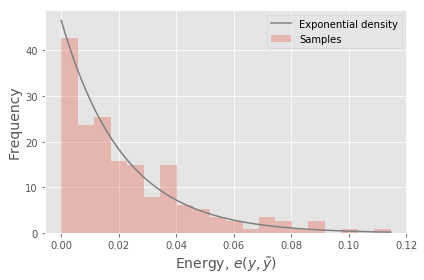

p: 0.021496046148071043


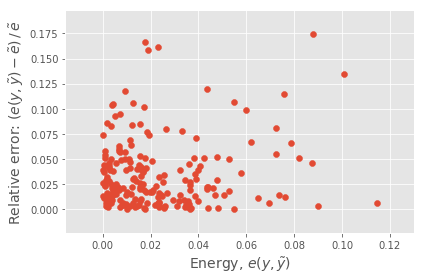

In [10]:
if RUN_DIFFUSION:
    # Sampling parameters.
    STEP_SIZE = 1e-2
    NUM_Y_TILDES = 200
    # ALPHA = 100
    
    METHOD = 'diffusion'
    print('\n\n--------- RUNNING {} ----------\n'.format(METHOD.upper()))
    (y_tildes_diffusion,
     energies_diffusion,
     energy_estimation_errors_diffusion) = sample_sp_exp_mech(e_opt,
                                                              energy_sensitivity,
                                                              x, y_opt, METHOD,
                                                              STEP_SIZE, NUM_Y_TILDES,
                                                              ALPHA)
    
    if PLOT:
        #plt.title('Energies with Diffusion, {} samples'.format(len(energies_diffusion)))
        plt.hist(energies_diffusion, bins=20, alpha=0.3, density=True, label='Samples')
        plt.xlabel(r'Energy, $e(y, \tilde{y})$', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        
        # Compare to Exponential density.
        p = exponential_param = 2. * energy_sensitivity / ALPHA
        xs = np.linspace(0, np.max(energies_diffusion), 100)
        xs_dens = 1 / p * np.exp(-xs / p)
        plt.plot(xs, xs_dens, c='gray', label='Exponential density')
        plt.legend()
        plt.tight_layout()
        plt.savefig('../output/fig_diffusion_energies.png')
        plt.show()
        print('p: {}'.format(p))
        
        # Scatter plot the errors.
        errs = energy_estimation_errors_diffusion
        plt.scatter(errs[:, 0], errs[:, 1])
        plt.xlabel(r'Energy, $e(y, \tilde{y})$', fontsize=14)
        plt.ylabel(r'Relative error: $(e(y, \tilde{y}) - \tilde{e}) \, / \, \tilde{e}$',
                   fontsize=14)
        plt.tight_layout()
        plt.savefig('../output/fig_diffusion_energy_errors.png')
        plt.show()


In [11]:
"""
# Compare to energies of e(y_opt, uniform)
baseline_energies = np.zeros(NUM_Y_TILDES)
for i in range(NUM_Y_TILDES):
    e_, _ = energy(y_opt, np.random.uniform(size=y_opt.shape))
    baseline_energies[i] = e_
plt.title('Energies with UNIFORM, n={}'.format(len(baseline_energies)))
plt.hist(baseline_energies, bins=20, alpha=0.3)
plt.show()
"""

"\n# Compare to energies of e(y_opt, uniform)\nbaseline_energies = np.zeros(NUM_Y_TILDES)\nfor i in range(NUM_Y_TILDES):\n    e_, _ = energy(y_opt, np.random.uniform(size=y_opt.shape))\n    baseline_energies[i] = e_\nplt.title('Energies with UNIFORM, n={}'.format(len(baseline_energies)))\nplt.hist(baseline_energies, bins=20, alpha=0.3)\nplt.show()\n"

#### Paper: Figure of private support point samples with various alphas.


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.5374 / 1.000) = Exp(1.0748)

Using diffusion mean:

Exp. mean: 1.07480, e_tilde: 1.07480
  step_size_factor: 1.00000, adjusted: 0.25 -> 0.25000
  Diffusion count 79460, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (1.18009 - 1.07480) / 1.07480 = 0.09796

Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.5374 / 10.000) = Exp(0.1075)

Using diffusion mean:

Exp. mean: 0.10748, e_tilde: 0.10748
  step_size_factor: 1.00000, adjusted: 0.01 -> 0.01000
  Diffusion count   727, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.10819 - 0.10748) / 0.10748 = 0.00658

Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.5374 / 100.000) = Exp(0.0107)

Using diffusion mean:

Exp. mean: 0.01075, e_tilde: 0.01075
  step_size_factor: 1.00000, adjusted: 0.01 -> 0.01000
  Diffusion count    12, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.01154 - 0.01075) / 0.01075 = 0.07329

Pr(e) ~ Exp(2U/a) = a / (2U) *

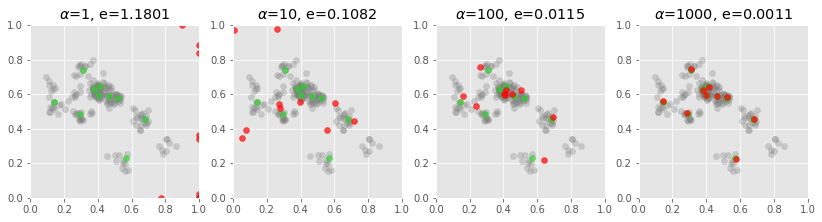

In [12]:
example_alphas = [1, 10, 100, 1000]
step_sizes = [0.25, 1e-2, 1e-2, 1e-3]
n_alp = len(example_alphas)
fig, axs = plt.subplots(1, n_alp, figsize=(3 * n_alp, 3))
for i, alpha in enumerate(example_alphas):
    np.random.seed(234)
    (y_tildes_diffusion,
     energies_diffusion,
     energy_errors_diffusion) = sample_sp_exp_mech(e_opt, energy_sensitivity,
                                                   x, y_opt, 'diffusion',
                                                   step_size=step_sizes[i],
                                                   num_y_tildes=1,
                                                   alpha=alpha,
                                                   diffusion_mean=True)

    axs[i].set_title(r'$\alpha$={}, e={:.4f}'.format(alpha,
                                                     energies_diffusion[0]))
    axs[i].scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3)
    axs[i].scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=0.7)
    axs[i].scatter(y_tildes_diffusion[0, :, 0],
                   y_tildes_diffusion[0, :, 1],
                   c='red', alpha=0.7)
    axs[i].set_xlim((0, 1))
    axs[i].set_ylim((0, 1))
        
plt.subplots_adjust(wspace=0.2, hspace=0.2,
                    bottom=0.1, top=0.9, left=0.05, right=0.95)
plt.savefig('../output/fig_sp_different_alphas.png')
plt.show()

## (CUT?) 5.1 Sample support points via MMD w/ DP median of pairwise distances

#### Paper: Figure of private support point samples with various alphas.

True median: 0.2181

STARTING RUN. is_tf: True, y_init: radial, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Analytical gradients not yet implemented for MMD.
  [*] Overall it/s: 0.0016


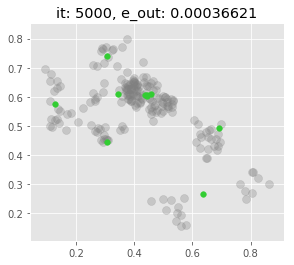

  [*] Time elapsed: 8.30807089805603


In [13]:
_MAX_ITER = 5001
_LR = 5e-4

# Compute median of pairwise distances, and use that as bandwidth.
median_pairwise_dists = np.median(pdist(x, 'minkowski', p=ENERGY_POWER))
sensitivity_median_pairwise_dists = DIM ** (1. / ENERGY_POWER) / 2.
print('True median: {:.4f}'.format(median_pairwise_dists))

# "True" support points using MMD.
y_opt_mmd, mmd_opt = get_support_points(x, N, _MAX_ITER, _LR,
                                        is_tf=IS_TF,
                                        plot=True,
                                        do_mmd=True,
                                        mmd_sigma=median_pairwise_dists)



STARTING RUN. is_tf: True, y_init: radial, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Analytical gradients not yet implemented for MMD.
  [*] Time elapsed: 7.874655485153198
  [*] Alpha: 1.0000, True median: 0.2181, Sampled: 0.9252

STARTING RUN. is_tf: True, y_init: radial, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Analytical gradients not yet implemented for MMD.
  [*] Time elapsed: 7.2869813442230225
  [*] Alpha: 10.0000, True median: 0.2181, Sampled: 0.2888

STARTING RUN. is_tf: True, y_init: radial, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Analytical gradients not yet implemented for MMD.
  [*] Time elapsed: 7.251759052276611
  [*] Alpha: 100.0000, True median: 0.2181, Sampled: 0.2252

STARTING RUN. is_tf: True, y_init: radial, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
  [*] Analytical gradients not yet implemented for MMD.
  [*] Time elapsed: 7.384217023849487
  [*] Alpha: 1000.0000

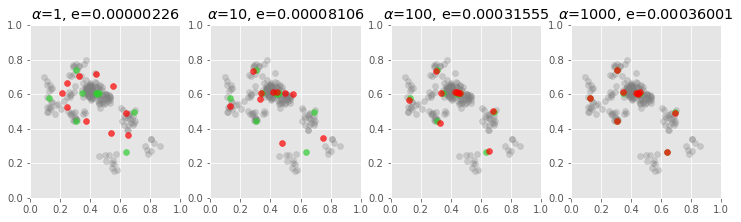

In [14]:
# Get private support points by using MMD with private bandwidth.
example_alphas = [1, 10, 100, 1000]
step_sizes = [0.25, 1e-2, 1e-2, 1e-3]
n_alp = len(example_alphas)
fig, axs = plt.subplots(1, n_alp, figsize=(3 * n_alp, 3))
for i, alpha in enumerate(example_alphas):
    # For this figure, use mean value of noise, instead of actual sample.
    (temp_y_opt_mmd,
     temp_mmd_opt) = sample_sp_mmd_dp_bw(x, ENERGY_POWER, DIM, alpha, N,
                                         plot=False, use_mean=True)
    
    
    
    axs[i].set_title(r'$\alpha$={}, e={:.8f}'.format(alpha,
                                                     temp_mmd_opt))
    axs[i].scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3)
    axs[i].scatter(y_opt_mmd[:, 0], y_opt_mmd[:, 1], c='limegreen', alpha=0.7)
    axs[i].scatter(temp_y_opt_mmd[:, 0], temp_y_opt_mmd[:, 1], c='red', alpha=0.7)
    axs[i].set_xlim((0, 1))
    axs[i].set_ylim((0, 1))

plt.subplots_adjust(wspace=0.2, hspace=0.2,
                    bottom=0.1, top=0.9, left=0.1, right=0.9)
plt.savefig('../output/fig_sp_mmd_dp_bw.png')
plt.show()

___

## 6. Expand to full data set.

## 6.0 KDE with pre-selected bandwidth.

#### Given privately sampled (by diffusion) SP, expand them using KDE and pre-selected bandwidth.

In [15]:
ALPHA = 100
STEP_SIZE = 1e-2

FULL_SAMPLE_SIZE = M
PLOT = 1


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.5374 / 100.000) = Exp(0.0107)

Using diffusion mean:

Exp. mean: 0.01075, e_tilde: 0.01075
  step_size_factor: 1.00000, adjusted: 0.01 -> 0.01000
  Diffusion count    12, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.01154 - 0.01075) / 0.01075 = 0.07329

Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.5374 / 100.000) = Exp(0.0107)

Using diffusion mean:

Exp. mean: 0.01075, e_tilde: 0.01075
  step_size_factor: 1.00000, adjusted: 0.01 -> 0.01000
  Diffusion count    12, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.01154 - 0.01075) / 0.01075 = 0.07329

Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.5374 / 100.000) = Exp(0.0107)

Using diffusion mean:

Exp. mean: 0.01075, e_tilde: 0.01075
  step_size_factor: 1.00000, adjusted: 0.01 -> 0.01000
  Diffusion count    12, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.01154 - 0.01075) / 0.01075 = 0.07329


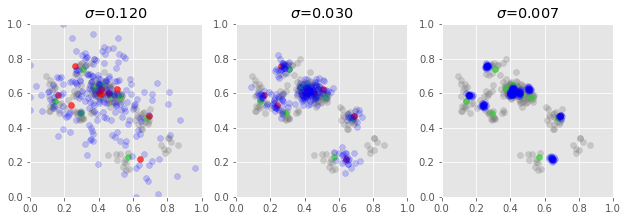

In [16]:
# Show data and y_tilde.
bandwidths = [SIGMA_DATA * 4, SIGMA_DATA, SIGMA_DATA / 4]
n_bw = len(bandwidths)

fig, axs = plt.subplots(1, n_bw, figsize=(3 * n_bw, 3))

for i, bw in enumerate(bandwidths):
    np.random.seed(234)
    (y_tilde,
     y_tilde_upsampled,
     y_tilde_expansion) = sample_full_set_by_diffusion(e_opt, energy_sensitivity,
                                                       x, y_opt, STEP_SIZE, ALPHA,
                                                       bw, FULL_SAMPLE_SIZE, 
                                                       plot=False, diffusion_mean=True)

    axs[i].set_title(r'$\sigma$={:.3f}'.format(bw))
    axs[i].scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3)
    axs[i].scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=0.7)
    axs[i].scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7)
    axs[i].scatter(y_tilde_expansion[:, 0], y_tilde_expansion[:, 1],
                   c='blue', alpha=0.2)
    axs[i].set_xlim((0, 1))
    axs[i].set_ylim((0, 1))
        
plt.subplots_adjust(wspace=0.2, hspace=0.2,
                    bottom=0.1, top=0.9, left=0.05, right=0.95)
plt.savefig('../output/fig_kde_fixed_bandwidth.png')

## 6.1 KDE with DP-MLE bandwidth.

#### Compute likelihood over a range of bandwidths, and compute likelihood for each.

In [17]:
ALPHA = 5
STEP_SIZE = 1e-2

PLOT = 1

In [18]:
np.random.seed(123)
ys, es, _ = sample_sp_exp_mech(e_opt, energy_sensitivity, x, y_opt,
                               'diffusion', STEP_SIZE, num_y_tildes=1,
                               alpha=ALPHA, diffusion_mean=True)
y_tilde = ys[0]

# Sample from mixture model centered on noisy support points.
choices = np.random.choice(range(len(y_tilde)), size=M)
y_tilde_upsampled = y_tilde[choices]


# Find optimal bandwidth using Maximum Likelihood.
BW_HIGH = 0.05
BW_LOW = 0.0001
NUM_BANDWIDTHS = 20
BW_RANGE = np.linspace(BW_HIGH, BW_LOW, NUM_BANDWIDTHS)

# Store bandwidth and likelihood pairs.
bw_lik = np.zeros((NUM_BANDWIDTHS, 2))

# Measure data likelihood under models centered on private support
# points, with a range of bandwidths.
for i, bw in enumerate(BW_RANGE): 
    #lik, do_log = mixture_model_likelihood(x, y_tilde, bw)
    lik, do_log = mixture_model_likelihood(x, y_tilde, bw)
    
    bw_lik[i] = [bw, lik]


# Print and plot all bandwidth-likelihood pairs.
bw_best, bw_best_lik = bw_lik[np.argmax(bw_lik, axis=0)[1]]
bw_worst, bw_worst_lik = bw_lik[np.argmin(bw_lik, axis=0)[1]]


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.5374 / 5.000) = Exp(0.2150)

Using diffusion mean:

Exp. mean: 0.21496, e_tilde: 0.21496
  step_size_factor: 1.00000, adjusted: 0.01 -> 0.01000
  Diffusion count   822, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.21645 - 0.21496) / 0.21496 = 0.00692
	 prod_liks=4.080e-08,
	 log_prod_liks=-1.701e+01,
	 sum_lliks=-1.701e+01


	 prod_liks=3.254e-07,
	 log_prod_liks=-1.494e+01,
	 sum_lliks=-1.494e+01


	 prod_liks=2.370e-06,
	 log_prod_liks=-1.295e+01,
	 sum_lliks=-1.295e+01


	 prod_liks=1.537e-05,
	 log_prod_liks=-1.108e+01,
	 sum_lliks=-1.108e+01


	 prod_liks=8.608e-05,
	 log_prod_liks=-9.360e+00,
	 sum_lliks=-9.360e+00


	 prod_liks=3.997e-04,
	 log_prod_liks=-7.825e+00,
	 sum_lliks=-7.825e+00


	 prod_liks=1.462e-03,
	 log_prod_liks=-6.528e+00,
	 sum_lliks=-6.528e+00


	 prod_liks=3.939e-03,
	 log_prod_liks=-5.537e+00,
	 sum_lliks=-5.537e+00


	 prod_liks=7.163e-03,
	 log_prod_liks=-4.939e+00,
	 sum_lliks=-4.939e

/home/maurice/privacy/mv_sp_privacy/src/sp_utils.py:902: RuntimeWarning: divide by zero encountered in log
  prod_liks, np.log(prod_liks), sum_lliks))
/home/maurice/privacy/mv_sp_privacy/src/sp_utils.py:903: RuntimeWarning: divide by zero encountered in log
  if prod_liks == 0. and np.log(prod_liks) == -np.Inf:


bw: 0.050000, llik: -1.70e+01
bw: 0.047374, llik: -1.49e+01
bw: 0.044747, llik: -1.30e+01
bw: 0.042121, llik: -1.11e+01
bw: 0.039495, llik: -9.36e+00
bw: 0.036868, llik: -7.82e+00
bw: 0.034242, llik: -6.53e+00
bw: 0.031616, llik: -5.54e+00
bw: 0.028989, llik: -4.94e+00
bw: 0.026363, llik: -4.85e+00
bw: 0.023737, llik: -5.44e+00
bw: 0.021111, llik: -6.93e+00
bw: 0.018484, llik: -9.68e+00
bw: 0.015858, llik: -1.43e+01
bw: 0.013232, llik: -2.17e+01
bw: 0.010605, llik: -3.43e+01
bw: 0.007979, llik: -5.80e+01
bw: 0.005353, llik: -1.14e+02
bw: 0.002726, llik: -3.34e+02
bw: 0.000100, llik: -1.79e+04


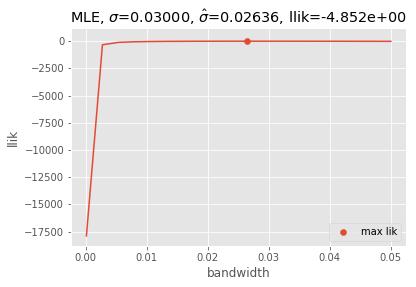

In [19]:
# Plot results for various bandwidths.
lik_str = 'llik' if do_log else 'lik'
for bw, lik in bw_lik:
    print('bw: {:.6f}, {}: {:.2e}'.format(bw, lik_str, lik))
plt.plot(bw_lik[:, 0], bw_lik[:, 1])
plt.scatter(bw_best, bw_best_lik, label='max lik')
plt.xlabel('bandwidth')
plt.ylabel(lik_str)
plt.title('MLE, $\sigma$={:.5f}, $\hat{{\sigma}}$={:.5f}, {}={:.3e}'.format(
    SIGMA_DATA, bw_best, lik_str, bw_best_lik))
plt.legend()
plt.savefig('../output/fig_kde_mle_bw.png')
plt.show()

#### Show samples with best and worst bandwidth.

	 prod_liks=3.153e+78,
	 log_prod_liks=1.807e+02,
	 sum_lliks=1.807e+02


	 prod_liks=7.810e-03,
	 log_prod_liks=-4.852e+00,
	 sum_lliks=-4.852e+00


do_log: True
P(x | y_opt, bw_best): 1.81e+02
P(x | y_tilde, bw_best): -4.85e+00


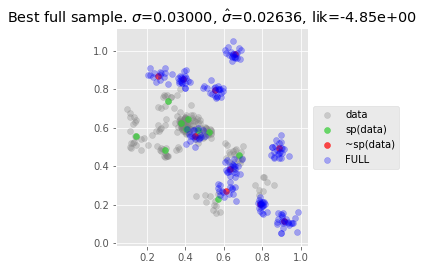

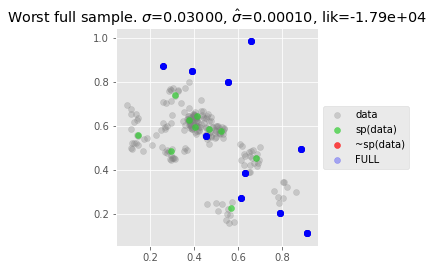

In [20]:
# Compare to likelihoods of data and optimal support points.
lik_y_opt, _ = mixture_model_likelihood(x, y_opt, bw_best,
                                        tag='Y_OPT, best bw: ')
lik_y_tilde, _ = mixture_model_likelihood(x, y_tilde, bw_best,
                                          tag='Y_TILDE, best bw: ')
print('do_log: {}'.format(do_log))
print('P(x | y_opt, bw_best): {:.2e}'.format(lik_y_opt))
print('P(x | y_tilde, bw_best): {:.2e}'.format(lik_y_tilde))


# Plot results.
new_sample_best = (
    y_tilde_upsampled + np.random.normal(0, bw_best,
                                         size=(FULL_SAMPLE_SIZE, x.shape[1])))
new_sample_worst = (
    y_tilde_upsampled + np.random.normal(0, bw_worst,
                                         size=(FULL_SAMPLE_SIZE, x.shape[1])))


if PLOT:
    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    plt.scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=0.7,
                label='sp(data)')
    plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7,
                label='~sp(data)')
    plt.scatter(new_sample_best[:, 0], new_sample_best[:, 1], c='blue', alpha=0.3,
                label='FULL')

    plt.title((r'Best full sample. $\sigma$={:.5f}, '
               '$\hat{{\sigma}}$={:.5f}, lik={:.2e}').format(SIGMA_DATA,
                                                             bw_best,
                                                             bw_best_lik))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    plt.scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen', alpha=0.7,
                label='sp(data)')
    plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7,
                label='~sp(data)')
    plt.scatter(new_sample_worst[:, 0], new_sample_worst[:, 1], c='blue',
                alpha=0.3, label='FULL')

    plt.title((r'Worst full sample. $\sigma$={:.5f}, '
                '$\hat{{\sigma}}$={:.5f}, lik={:.2e}').format(SIGMA_DATA,
                                                              bw_worst,
                                                              bw_worst_lik))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

#### Sample full synthetic set with DP sample of MLE bandwidth.

In this setting, for positive bandwidth $\sigma$, Gaussian data up to $4\sigma$ is bounded on $[0, 1]$ by restricting cluster centers to $[0 + 4\sigma, 1 - 4\sigma]$. The largest $\sigma$ that accommodates this bound is $\sigma = 1/8$. With sensitivity $\Delta f = 1/8$, we sample a DP bandwidth $\tilde{\sigma} \sim \mbox{Lap}(\sigma, \frac{1/8}{\alpha})$, and enforce a non-trivially small positive floor value $\delta$, with $\max(\tilde{\sigma}, \delta)$.


Best bw:       0.026363
raw DP bw:     0.024739
Corrected DP bw: 0.024739

Best bw:       0.026363
raw DP bw:     0.060358
Corrected DP bw: 0.060358

Best bw:       0.026363
raw DP bw:     0.047064
Corrected DP bw: 0.047064

Best bw:       0.026363
raw DP bw:     0.022962
Corrected DP bw: 0.022962


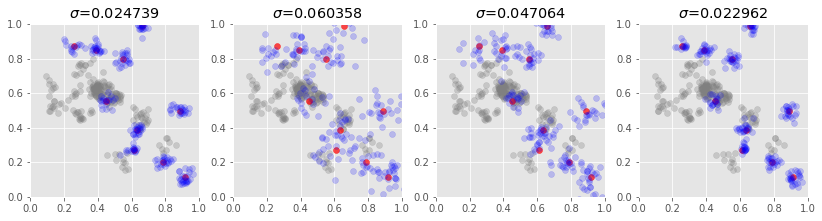

In [21]:
dp_bandwidths = []
floor = 1e-3
n_bw = 4

for _ in range(n_bw):
    dp_bandwidth_raw = bw_best + np.random.laplace(loc=0, scale=(1 / 8) / ALPHA)
    dp_bandwidth = np.max([dp_bandwidth_raw, floor])
    dp_bandwidths.append(dp_bandwidth)
    print('\nBest bw: {:>14.6f}\nraw DP bw: {:>12.6f}\nCorrected DP bw: {:>1.6f}'.format(
            bw_best, dp_bandwidth_raw, dp_bandwidth))



fig, axs = plt.subplots(1, n_bw, figsize=(3 * n_bw, 3))

for i, bw in enumerate(dp_bandwidths):
    y_tilde_expansion = (
        y_tilde_upsampled +
        np.random.normal(0, bw, size=(FULL_SAMPLE_SIZE, x.shape[1])))
    
    
    #(y_tilde,
    # y_tilde_upsampled,
    # y_tilde_expansion) = sample_full_set_by_diffusion(e_opt, energy_sensitivity,
    #                                                   x, y_opt, STEP_SIZE, ALPHA,
    #                                                   bw, FULL_SAMPLE_SIZE, 
    #                                                   plot=False, diffusion_mean=True)

    axs[i].set_title(r'$\sigma$={:.6f}'.format(bw))
    axs[i].scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3)
    axs[i].scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7)
    axs[i].scatter(y_tilde_expansion[:, 0], y_tilde_expansion[:, 1],
                   c='blue', alpha=0.2)
    axs[i].set_xlim((0, 1))
    axs[i].set_ylim((0, 1))
        
plt.subplots_adjust(wspace=0.2, hspace=0.2,
                    bottom=0.1, top=0.9, left=0.05, right=0.95)
plt.savefig('../output/fig_kde_dp_mle.png')

## (CUT?) 6.2 KDE with DP median of pairwise distances as bandwidth.

Choose W based on data (median heuristics). Add DP noise to W, i.e. add $\eta \sim \mbox{Lap}(2^{(1/p)} / 2)$. Get SP with MMD_W. Do KDE with W. <- WITH WHAT BANDWIDTH?

0.2181316421159279
0.2183437641631669

Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.5374 / 1000.000) = Exp(0.0011)


Exp. mean: 0.00107, e_tilde: 0.00003
  step_size_factor: 0.03146, adjusted: 0.002 -> 0.00006
  Diffusion count     3, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.00005 - 0.00003) / 0.00003 = 0.44582


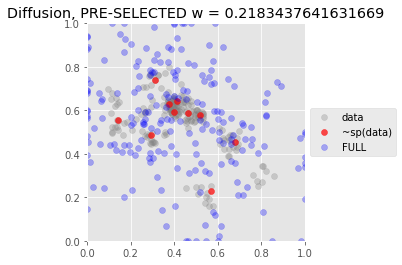

In [22]:
# Show data and y_tilde.
ALPHA=1000
STEP_SIZE = 2e-3
SAMPLE_SIZE = M


# Compute median of pairwise distanes, and use that as bandwidth.
median_pairwise_dists = np.median(pdist(x, 'minkowski', p=ENERGY_POWER))
sensitivity_median_pairwise_dists = DIM ** (1. / ENERGY_POWER) / 2.
private_median = (median_pairwise_dists +
                  np.random.laplace(
                      scale=sensitivity_median_pairwise_dists / ALPHA))
print(median_pairwise_dists)
print(private_median)
BANDWIDTH = private_median

# Sample support points using private median.
# First  : Derive support points using MMD with private median.
# Second : Expand using kernel density estimator.
np.random.seed(234)
(y_tilde,
 y_tilde_upsampled,
 y_tilde_expansion) = sample_full_set_by_diffusion(e_opt, energy_sensitivity,
                                                   x, y_opt, STEP_SIZE, ALPHA,
                                                   BANDWIDTH, SAMPLE_SIZE)

plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7, label='~sp(data)')
plt.scatter(y_tilde_expansion[:, 0], y_tilde_expansion[:, 1], c='blue', 
            alpha=0.3, label='FULL')

plt.title('Diffusion, PRE-SELECTED w = {}'.format(BANDWIDTH))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


## 6.3 Repeated draws of private support points.


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.5374 / 50.000) = Exp(0.0215)


Exp. mean: 0.02150, e_tilde: 0.03963
  step_size_factor: 0.92181, adjusted: 0.005 -> 0.00461
  Diffusion count   370, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.04014 - 0.03963) / 0.03963 = 0.01292

Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.5374 / 50.000) = Exp(0.0215)


Exp. mean: 0.02150, e_tilde: 0.10234
  step_size_factor: 2.38042, adjusted: 0.005 -> 0.01190
  Diffusion count   289, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.10389 - 0.10234) / 0.10234 = 0.01518

Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.5374 / 50.000) = Exp(0.0215)


Exp. mean: 0.02150, e_tilde: 0.01549
  step_size_factor: 0.72059, adjusted: 0.005 -> 0.00360
  Diffusion count   259, e_opt:  0.002938, (e(y, y~) - e~) / e~ = error%: (0.01549 - 0.01549) / 0.01549 = 0.00010

Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.5374 / 50.000) = Exp(0.0215)



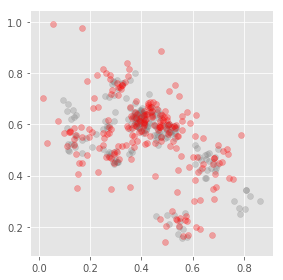

In [27]:
ALPHA = 50
STEP_SIZE = 5e-3

BANDWIDTH = SIGMA_DATA
NUM_REPEATS = int(M / N) + 1


new_sample = []

for i in range(NUM_REPEATS):
    (y_tilde,
     y_tilde_upsampled,
     y_tilde_expansion) = sample_full_set_by_diffusion(e_opt, energy_sensitivity,
                                                       x, y_opt, STEP_SIZE,
                                                       ALPHA, BANDWIDTH,
                                                       FULL_SAMPLE_SIZE)
    new_sample.append(y_tilde)


new_sample = np.concatenate(new_sample)

print('\nConcatenating results, and plotting collection of samples as one.\n')
print('Diffusion, alpha={}, repeats={}, budget={},\n n={}, bw={}'.format(
    ALPHA, NUM_REPEATS, ALPHA * float(NUM_REPEATS), len(new_sample),
    BANDWIDTH))

plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
# plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7, label='~sp(data)')
plt.scatter(new_sample[:, 0], new_sample[:, 1], c='red', alpha=0.3, label='FULL')
#plt.title('Diffusion, alpha={}, repeats={}, budget={},\n n={}, bw={}'.format(
#    ALPHA, NUM_REPEATS, ALPHA * float(NUM_REPEATS), len(new_sample),
#    BANDWIDTH))
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.xlim(0, 1)
#plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig('../output/fig_repeated_samples.png')
plt.show()

# End.